<center><a href="https://5loi.com/about_loi"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

## 使用大型语言模型进行标记分类
> Token Classification with Large Language Models

### 02 - 领域特定标记分类模型
> Domain-Specific Token Classification Model

在本笔记本中，您将学习如何微调预训练语言模型以对特定领域执行标记分类。具体来说，您将开发一个命名实体识别（NER）模型，用于在医学疾病摘要中查找疾病名称。

**目录**<br>
本笔记本涵盖以下部分：
* 项目概述
* 数据集
    * 下载数据
    * 预处理数据
* 为自定义领域微调预训练模型
    * 配置文件
    * 下载领域特定预训练模型
    * 练习 # 1 - 实例化模型和训练器
    * 练习 # 2 - 模型训练
    * 模型评估

* Project Overview
* Dataset
    * Download Data
    * Preprocess Data
* Fine-Tune a Pre-Trained Model for Custom Domain
    * Configuration File
    * Download Domain-Specific Pre-Trained Model
    * Exercise # 1 - Instantiate Model and Trainer
    * Exercise # 2 - Model Training
    * Model Evaluation

## 项目概述 ##
> Project Overview

<img src='images/workflow.png' width=1080>

## 数据集 ##
> Dataset

对于本笔记本，我们将使用[NCBI-disease](https://www.ncbi.nlm.nih.gov/CBBresearch/Dogan/DISEASE/)语料库，它是一组由 14 位注释者注释的 793 篇 PubMed 摘要。注释采用 HTML 样式标签的形式插入摘要文本中，并使用清晰定义的规则。注释识别命名疾病，并可用于微调语言模型，以识别未来摘要中的疾病提及，*无论这些疾病是否属于原始训练集*。


### 下载数据 ###
> Download Data

In [1]:
import os  # 导入操作系统的库
import wget  # 导入 wget 库，用于下载文件

# 设置数据路径
DATA_DIR = "data/NCBI"  # 定义数据文件夹的路径
os.makedirs(DATA_DIR, exist_ok=True)  # 创建数据文件夹，如果文件夹已存在则不进行操作


以下是语料库中带注释的摘要示例：

In [2]:
# 打开 NCBI_corpus_testing.txt 文件并读取第一行
with open(f'{DATA_DIR}/NCBI_corpus_testing.txt') as f:
    sample_text=f.readline()  # 读取文件的第一行
    
print(sample_text)  # 打印读取的文本内容


9288106	Clustering of missense mutations in the <category="Modifier">ataxia-telangiectasia</category> gene in a <category="SpecificDisease">sporadic T-cell leukaemia</category>.	<category="SpecificDisease">Ataxia-telangiectasia</category> ( <category="SpecificDisease">A-T</category> ) is a <category="DiseaseClass">recessive multi-system disorder</category> caused by mutations in the ATM gene at 11q22-q23 ( ref . 3 ) . The risk of <category="DiseaseClass">cancer</category> , especially <category="DiseaseClass">lymphoid neoplasias</category> , is substantially elevated in <category="Modifier">A-T</category> patients and has long been associated with chromosomal instability . By analysing <category="Modifier">tumour</category> DNA from patients with <category="SpecificDisease">sporadic T-cell prolymphocytic leukaemia</category> ( <category="SpecificDisease">T-PLL</category> ) , a rare <category="DiseaseClass">clonal malignancy</category> with similarities to a <category="SpecificDisease">

在此示例中，我们看到摘要中包含以下标签：

In [3]:
import re  # 导入正则表达式库

# 使用正则表达式查找标签
categories=re.findall('<category.*?<\/category>', sample_text)  # 使用正则表达式查找所有以 `<category>` 开头，以 `</category>` 结尾的字符串
for sample in categories:
    print(sample)  # 打印每个找到的标签


<category="Modifier">ataxia-telangiectasia</category>
<category="SpecificDisease">sporadic T-cell leukaemia</category>
<category="SpecificDisease">Ataxia-telangiectasia</category>
<category="SpecificDisease">A-T</category>
<category="DiseaseClass">recessive multi-system disorder</category>
<category="DiseaseClass">cancer</category>
<category="DiseaseClass">lymphoid neoplasias</category>
<category="Modifier">A-T</category>
<category="Modifier">tumour</category>
<category="SpecificDisease">sporadic T-cell prolymphocytic leukaemia</category>
<category="SpecificDisease">T-PLL</category>
<category="DiseaseClass">clonal malignancy</category>
<category="SpecificDisease">mature T-cell leukaemia</category>
<category="SpecificDisease">A-T</category>
<category="SpecificDisease">T-PLL</category>
<category="SpecificDisease">A-T</category>
<category="DiseaseClass">leukaemia</category>
<category="SpecificDisease">T-PLL</category>
<category="Modifier">A-T</category>
<category="Modifier">tumour</catego

出于我们的目的，我们将任何已识别的类别（例如“修饰符”、“特定疾病”和其他一些类别）大体上视为“疾病”。如果您想查看更多示例，可以使用左侧的文件浏览器浏览语料库的文本，或直接打开文件：

* [data/NCBI/NCBI_corpus_training.txt](data/NCBI/NCBI_corpus_training.txt)
* [data/NCBI/NCBI_corpus_testing.txt](data/NCBI/NCBI_corpus_testing.txt)
* [data/NCBI/NCBI_corpus_development.txt](data/NCBI/NCBI_corpus_development.txt)

我们已经从此语料库中派生了一个数据集。对于 NER，数据集将单个单词标记为疾病。
 

In [4]:
NER_DATA_DIR = f'{DATA_DIR}/NER'  # 定义 NER 数据文件夹的路径
os.makedirs(os.path.join(DATA_DIR, 'NER'), exist_ok=True)  # 创建 NER 数据文件夹，如果文件夹已存在则不进行操作

# 显示下载的文件
!ls -lh $NER_DATA_DIR  # 使用 shell 命令 ls 列出 NER 数据文件夹的内容，并显示详细信息，例如文件大小和权限


total 1.5M
-rw-r--r-- 1 root root 196K Sep 26 07:57 dev.tsv
-rw-r--r-- 1 root root 201K Sep 26 07:57 test.tsv
-rw-r--r-- 1 root root 1.1M Sep 26 07:57 train.tsv


In [5]:
# 显示 train.tsv 文件的内容
!head $NER_DATA_DIR/train.tsv  # 使用 shell 命令 head 打印 train.tsv 文件的内容


Identification	O
of	O
APC2	O
,	O
a	O
homologue	O
of	O
the	O
adenomatous	B-Disease
polyposis	I-Disease


_注意:_ 我们可以看到摘要已分解成句子。然后，每个句子进一步解析成带有标签的单词，这些标签对应于语料库中原始的 HTML 样式标签。

### 预处理数据 ###
> Preprocess Data

我们需要将这些数据转换为与 NeMo 标记分类模块兼容的格式。为方便起见，我们提供了此转换的脚本[此处](https://github.com/NVIDIA/NeMo/blob/stable/examples/nlp/token_classification/data/import_from_iob_format.py)。. 

In [6]:
# 调用转换脚本
!python import_from_iob_format.py --data_file=$NER_DATA_DIR/train.tsv  # 执行 import_from_iob_format.py 脚本，并将 train.tsv 文件作为输入
!python import_from_iob_format.py --data_file=$NER_DATA_DIR/dev.tsv  # 执行 import_from_iob_format.py 脚本，并将 dev.tsv 文件作为输入
!python import_from_iob_format.py --data_file=$NER_DATA_DIR/test.tsv  # 执行 import_from_iob_format.py 脚本，并将 test.tsv 文件作为输入


NOTE! Installing ujson may make loading annotations faster.
[NeMo I 2024-09-26 08:13:28 import_from_iob_format:119] Processing data/NCBI/NER/train.tsv
[NeMo I 2024-09-26 08:13:28 import_from_iob_format:124] Processing of the data/NCBI/NER/train.tsv is complete
NOTE! Installing ujson may make loading annotations faster.
[NeMo I 2024-09-26 08:13:32 import_from_iob_format:119] Processing data/NCBI/NER/dev.tsv
[NeMo I 2024-09-26 08:13:32 import_from_iob_format:124] Processing of the data/NCBI/NER/dev.tsv is complete
NOTE! Installing ujson may make loading annotations faster.
[NeMo I 2024-09-26 08:13:37 import_from_iob_format:119] Processing data/NCBI/NER/test.tsv
[NeMo I 2024-09-26 08:13:37 import_from_iob_format:124] Processing of the data/NCBI/NER/test.tsv is complete


#### IOB 标记与疾病命名实体识别

请回忆，NER 数据集中句子和标签的对应关系是通过**内部、外部、开始（IOB）**标记实现的。任何以空格分隔的部分都被视为一个词，包括标点符号。这种机制可以广泛应用于多种命名实体类型：

* B-{CHUNK_TYPE} – 标记**开头**块中的词
* I-{CHUNK_TYPE} – 标记块**内部**的词
* O – 标记任何块**外部**的词

在我们的例子中，我们只关注“疾病”作为我们的实体（或块）类型，因此我们不需要识别这三种类别之外的其他类别：I、O 和 B。

**三种类别**

* B - 疾病名称的**开头**
* I - 疾病名称**内部**的词
* O - 所有疾病名称**外部**

例如，对于第一个句子，我们有以下映射：

```text
Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .
O              O  O    O O O         O  O   B           I         I    I      O          O  
```

为了进行比较，原始语料库标签如下所示：

```html
Identification of APC2, a homologue of the <category="Modifier">adenomatous polyposis coli tumour</category> suppressor.
```

标记文本的第一个词“adenomatous”现在被 IOB 标记为**B**（开头）标签，疾病的其他部分“polyposis coli tumour”被标记为**I**（内部）标签，其他所有内容都被标记为**O**（外部）。


In [7]:
# 预览数据集
!head -n 1 $NER_DATA_DIR/text_train.txt  # 使用 shell 命令 head 打印 text_train.txt 文件的第一行
!head -n 1 $NER_DATA_DIR/labels_train.txt  # 使用 shell 命令 head 打印 labels_train.txt 文件的第一行


Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor . 
O O O O O O O O B-Disease I-Disease I-Disease I-Disease O O 


## 为自定义领域微调预训练模型 ##
> Fine-Tune a Pre-Trained Model for Custom Domain

命名实体识别模型通常由一个预训练的[BERT](https://arxiv.org/pdf/1810.04805.pdf)模型和一个标记分类层组成。为了进行训练，我们可以使用配置文件来定义模型。配置文件包含几个重要的部分，包括：

* **model**: 所有与模型相关的参数 - 语言模型、标记分类器、优化器和调度器、数据集以及任何其他相关信息
* **trainer**: 传递给 PyTorch Lightning 的任何参数

_注意:_ NeMo 提供了一个创建配置文件的模板，建议将其作为起点，但只要遵循所需格式，您也可以创建自己的配置文件。

### 配置文件 ###
> Configuration File

In [8]:
# 定义配置文件路径
MODEL_CONFIG = "token_classification_config.yaml"  # 定义配置文件名称
WORK_DIR = "WORK_DIR"  # 定义工作目录
os.makedirs(WORK_DIR, exist_ok=True)  # 创建工作目录，如果目录已存在则不进行操作


In [9]:
# 下载模型的配置文件
BRANCH = 'main'  # 定义 GitHub 分支名称
config_dir = WORK_DIR + '/configs/'  # 定义配置文件目录
os.makedirs(config_dir, exist_ok=True)  # 创建配置文件目录，如果目录已存在则不进行操作

if not os.path.exists(config_dir + MODEL_CONFIG):  # 检查配置文件是否存在
    print('下载配置文件...')  # 打印提示信息
    wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/examples/nlp/token_classification/conf/' + MODEL_CONFIG, config_dir)  # 从 GitHub 仓库下载配置文件
else:
    print ('配置文件已存在')  # 打印提示信息


下载配置文件...


NER 的配置文件 `token_classification_config.yaml` 指定了模型、训练和实验管理细节，例如文件位置、预训练模型和超参数。我们下载的 YAML 配置文件为大多数参数提供了默认值，但此实验必须指定一些项目。

使用 `omegaconf` 包可以更轻松地查看每个 YAML 部分，它允许您使用“点”表示法访问和操作配置键。我们将使用 `OmegaConf` 工具查看每个部分的详细信息。


In [10]:
from omegaconf import OmegaConf  # 导入 OmegaConf 库，用于加载和操作配置文件

CONFIG_DIR = "/dli/task/WORK_DIR/configs"  # 定义配置文件目录
CONFIG_FILE = "token_classification_config.yaml"  # 定义配置文件名称

config=OmegaConf.load(CONFIG_DIR + "/" + CONFIG_FILE)  # 加载配置文件

# 打印整个配置文件
print(OmegaConf.to_yaml(config))  # 打印配置文件的内容，以 YAML 格式输出


pretrained_model: null
trainer:
  devices: 1
  num_nodes: 1
  max_epochs: 5
  max_steps: -1
  accumulate_grad_batches: 1
  gradient_clip_val: 0.0
  precision: 16
  accelerator: gpu
  enable_checkpointing: false
  logger: false
  log_every_n_steps: 1
  val_check_interval: 1.0
exp_manager:
  exp_dir: null
  name: token_classification_model
  create_tensorboard_logger: true
  create_checkpoint_callback: true
model:
  label_ids: null
  class_labels:
    class_labels_file: label_ids.csv
  dataset:
    data_dir: ???
    class_balancing: null
    max_seq_length: 128
    pad_label: O
    ignore_extra_tokens: false
    ignore_start_end: false
    use_cache: false
    num_workers: 2
    pin_memory: false
    drop_last: false
  train_ds:
    text_file: text_train.txt
    labels_file: labels_train.txt
    shuffle: true
    num_samples: -1
    batch_size: 64
  validation_ds:
    text_file: text_dev.txt
    labels_file: labels_dev.txt
    shuffle: false
    num_samples: -1
    batch_size: 64
  test_

请注意，某些配置文件行，包括 `model.dataset.data_dir`，在路径位置使用 `???`，这意味着用户需要指定这些字段的值。有关模型参数的详细信息，请参阅[文档](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/token_classification.html#training-the-token-classification-model)。

In [11]:
# 在本练习中，训练和开发数据集位于相同文件夹下，并使用默认名称，因此只需将数据目录的路径添加到配置中即可
config.model.dataset.data_dir = os.path.join(DATA_DIR, 'NER')  # 更新配置文件中的数据目录路径

# 打印模型部分

print(OmegaConf.to_yaml(config.model))  # 打印配置文件中模型部分的内容，以 YAML 格式输出

label_ids: null
class_labels:
  class_labels_file: label_ids.csv
dataset:
  data_dir: data/NCBI/NER
  class_balancing: null
  max_seq_length: 128
  pad_label: O
  ignore_extra_tokens: false
  ignore_start_end: false
  use_cache: false
  num_workers: 2
  pin_memory: false
  drop_last: false
train_ds:
  text_file: text_train.txt
  labels_file: labels_train.txt
  shuffle: true
  num_samples: -1
  batch_size: 64
validation_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 64
test_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 64
tokenizer:
  tokenizer_name: ${model.language_model.pretrained_model_name}
  vocab_file: null
  tokenizer_model: null
  special_tokens: null
language_model:
  pretrained_model_name: bert-base-uncased
  lm_checkpoint: null
  config_file: null
  config: null
head:
  num_fc_layers: 2
  fc_dropout: 0.5
  activation: relu
  use_transformer_init: true


_注意:_ 已修改必需的 `model.dataset.data_dir` 参数（用于标记分类）。

### 下载领域特定预训练模型 ###
> Download Domain-Specific Pre-Trained Model

对于此标记分类任务，我们可以从预训练的 `BioMegatron` 语言模型开始。`BioMegatron` 模型是在大型生物医学文本语料库上训练的、特定于领域的、类似 BERT 的 Megatron-LM 模型。由于该模型是在特定于领域的文本上训练的，因此与通用语言模型相比，我们可以预期它在识别疾病方面具有更好的性能。

_注意：_BioMegatron 还有一些替代方案，例如 BioBERT。值得尝试不同的预训练模型，以找到最适合特定任务的模型。


In [12]:
# 导入依赖项
from nemo.collections.nlp.models.language_modeling.megatron_bert_model import MegatronBertModel  # 导入 MegatronBertModel 类，用于加载和使用 Megatron-BERT 模型

# 列出可用的预训练模型
for model in MegatronBertModel.list_available_models():  # 遍历 MegatronBertModel 类中定义的可用预训练模型
    print(model.pretrained_model_name)  # 打印每个模型的预训练模型名称


NOTE! Installing ujson may make loading annotations faster.
megatron_bert_345m_cased
megatron_bert_345m_uncased
biomegatron345m_biovocab_50k_cased
biomegatron345m_biovocab_50k_uncased
biomegatron345m_biovocab_30k_cased
biomegatron345m_biovocab_30k_uncased
biomegatron-bert-345m-cased
biomegatron-bert-345m-uncased


为了加载预训练的 BERT LM 模型，我们更改了配置文件中的 `model.language_mode` 参数以及其他一些参数。

In [13]:
# 将上述指定的模型参数添加到配置中
MODEL_NAME='biomegatron345m_biovocab_30k_cased'  # 定义要使用的预训练模型名称
# MODEL_NAME='biomegatron-bert-345m-cased'  # 也可以选择使用这个预训练模型

config.model.language_model.lm_checkpoint=None  # 设置语言模型的检查点路径，这里设置为 None，表示不使用检查点
config.model.language_model.pretrained_model_name=MODEL_NAME  # 设置语言模型的预训练模型名称
config.model.tokenizer.tokenizer_name=None  # 设置分词器的名称，这里设置为 None，表示使用默认的分词器

# 根据 GPU 容量使用合适的配置
config.model.dataset_max_seq_length=64  # 设置数据集的最大序列长度
config.model.train_ds.batch_size=32  # 设置训练数据集的批次大小
config.model.validation_ds.batch_size=32  # 设置验证数据集的批次大小
config.model.test_ds.batch_size=32  # 设置测试数据集的批次大小

# 限制本演示的 epochs 数
config.trainer.max_epochs=1  # 设置最大 epochs 数，这里限制为 1
# config.trainer.precision=16  # 设置训练精度，这里设置为 16 位浮点数，可以加快训练速度
# config.trainer.amp_level='O1'  # 设置混合精度训练级别，这里设置为 'O1'，可以加快训练速度


_注意:_ 一旦 `token_classification_config.yaml` 文件加载到内存中，更改配置文件将需要重新定义 `config` 变量。

现在，我们准备初始化我们的模型。在模型初始化调用期间，将为训练和评估准备数据集和数据加载器。此外，将下载预训练的 BERT 模型，这可能需要几分钟，具体取决于所选 BERT 模型的大小。

#### 练习 # 1 - 实例化模型和训练器 ####
> Instantiate Model and Trainer

* 修改 `<FIXME>` 以基于配置文件和训练器实例化 `TokenClassificationModel`。

In [14]:
from nemo.collections.nlp.models import TokenClassificationModel  # 导入 TokenClassificationModel 类，用于命名实体识别任务
import pytorch_lightning as pl  # 导入 PyTorch Lightning 库，用于深度学习模型训练和评估

trainer=pl.Trainer(**config.trainer)  # 创建一个训练器，使用配置文件中的 `trainer` 部分配置
ner_model=TokenClassificationModel(cfg=config.model, trainer=trainer)  # 创建一个命名实体识别模型，使用配置文件中的 `model` 部分配置和训练器

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
[NeMo W 2024-09-26 08:14:33 lm_utils:91] biomegatron345m_biovocab_30k_cased is not in get_pretrained_lm_models_list(include_external=False), will be using AutoModel from HuggingFace.


[NeMo I 2024-09-26 08:14:33 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/biomegatron345m_biovocab_30k_cased/versions/1/files/BioMegatron345m-biovocab-30k-cased.nemo to /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo
[NeMo I 2024-09-26 08:14:38 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2024-09-26 08:14:40 megatron_init:234] Rank 0 has data parallel group: [0]
[NeMo I 2024-09-26 08:14:40 megatron_init:237] All data parallel group ranks: [[0]]
[NeMo I 2024-09-26 08:14:40 megatron_init:238] Ranks 0 has data parallel rank: 0
[NeMo I 2024-09-26 08:14:40 megatron_init:246] Rank 0 has model parallel group: [0]
[NeMo I 2024-09-26 08:14:40 megatron_init:247] All model parallel group ranks: [[0]]
[NeMo I 2024-09-26 08:14:40 megatron_init:257] Rank 0 has tensor model parallel group: [0]
[NeMo I 2024-09-26 08:14:40 megatron_init:261] All tensor mo

[NeMo W 2024-09-26 08:14:40 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.


[NeMo I 2024-09-26 08:14:40 tokenizer_utils:204] Getting Megatron tokenizer for pretrained model name: megatron-bert-345m-cased, custom vocab file: /tmp/tmpp6eipx9o/f67afcc805164750a9eb2aa564aaf9a9_pubmed_merged-all-cased.vocab.txt, and merges file: None
[NeMo I 2024-09-26 08:14:40 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-large-cased, vocab_file: /tmp/tmpp6eipx9o/f67afcc805164750a9eb2aa564aaf9a9_pubmed_merged-all-cased.vocab.txt, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.


[NeMo I 2024-09-26 08:14:40 megatron_base_model:264] Padded vocab_size: 31104, original vocab_size: 31079, dummy tokens: 25.
[NeMo I 2024-09-26 08:14:41 save_restore_connector:249] Model MegatronBertModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo.
[NeMo I 2024-09-26 08:14:41 token_classification_utils:118] Processing data/NCBI/NER/labels_train.txt
[NeMo I 2024-09-26 08:14:41 token_classification_utils:154] Labels mapping {'O': 0, 'B-Disease': 1, 'I-Disease': 2} saved to : data/NCBI/NER/label_ids.csv
[NeMo I 2024-09-26 08:14:41 token_classification_utils:163] Three most popular labels in data/NCBI/NER/labels_train.txt:
[NeMo I 2024-09-26 08:14:41 data_preprocessing:194] label: 0, 124819 out of 136086 (91.72%).
[NeMo I 2024-09-26 08:14:41 data_preprocessing:194] label: 2, 6122 out of 136086 (4.50%).
[NeMo I 2024-09-26 08:14:41 data_preprocessing:194] label:

[NeMo W 2024-09-26 08:14:48 token_classification_dataset:152] 3 are longer than 128


[NeMo I 2024-09-26 08:14:48 token_classification_dataset:155] *** Example ***
[NeMo I 2024-09-26 08:14:48 token_classification_dataset:156] i: 0
[NeMo I 2024-09-26 08:14:48 token_classification_dataset:157] subtokens: [CLS] Identification of APC ##2 , a homologue of the adenoma ##to ##us polyp ##osis coli tumour suppressor . [SEP]
[NeMo I 2024-09-26 08:14:48 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 08:14:48 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 

[NeMo W 2024-09-26 08:14:50 token_classification_dataset:152] 0 are longer than 99


[NeMo I 2024-09-26 08:14:50 token_classification_dataset:155] *** Example ***
[NeMo I 2024-09-26 08:14:50 token_classification_dataset:156] i: 0
[NeMo I 2024-09-26 08:14:50 token_classification_dataset:157] subtokens: [CLS] BRCA ##1 is secreted and exhibits properties of a gran ##in . [SEP]
[NeMo I 2024-09-26 08:14:50 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 08:14:50 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 08:14:50 token_classification_dataset:160] subtokens_mask: 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[NeMo W 2024-09-26 08:14:52 token_classification_dataset:152] 0 are longer than 99


[NeMo I 2024-09-26 08:14:52 token_classification_dataset:155] *** Example ***
[NeMo I 2024-09-26 08:14:52 token_classification_dataset:156] i: 0
[NeMo I 2024-09-26 08:14:52 token_classification_dataset:157] subtokens: [CLS] BRCA ##1 is secreted and exhibits properties of a gran ##in . [SEP]
[NeMo I 2024-09-26 08:14:52 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 08:14:52 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 08:14:52 token_classification_dataset:160] subtokens_mask: 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[NeMo W 2024-09-26 08:14:52 lm_utils:91] biomegatron345m_biovocab_30k_cased is not in get_pretrained_lm_models_list(include_external=False), will be using AutoModel from HuggingFace.


[NeMo I 2024-09-26 08:14:52 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo.
[NeMo I 2024-09-26 08:14:52 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo
[NeMo I 2024-09-26 08:14:52 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2024-09-26 08:14:53 megatron_init:234] Rank 0 has data parallel group: [0]
[NeMo I 2024-09-26 08:14:53 megatron_init:237] All data parallel group ranks: [[0]]
[NeMo I 2024-09-26 08:14:53 megatron_init:238] Ranks 0 has data parallel rank: 0
[NeMo I 2024-09-26 08:14:53 megatron_init:246] Rank 0 has model parallel group: [0]
[NeMo I 2024-09-26 08:14:53 megatron_init:247] All model parallel group ranks: [[0]]
[NeMo I 2024-09-26 08:14:53 megatron_init:257] Rank 0 has tensor model parallel group: [

[NeMo W 2024-09-26 08:14:53 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.


[NeMo I 2024-09-26 08:14:53 tokenizer_utils:204] Getting Megatron tokenizer for pretrained model name: megatron-bert-345m-cased, custom vocab file: /tmp/tmp_r0ub3ms/f67afcc805164750a9eb2aa564aaf9a9_pubmed_merged-all-cased.vocab.txt, and merges file: None
[NeMo I 2024-09-26 08:14:53 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-large-cased, vocab_file: /tmp/tmp_r0ub3ms/f67afcc805164750a9eb2aa564aaf9a9_pubmed_merged-all-cased.vocab.txt, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.


[NeMo I 2024-09-26 08:14:53 megatron_base_model:264] Padded vocab_size: 31104, original vocab_size: 31079, dummy tokens: 25.
[NeMo I 2024-09-26 08:14:54 save_restore_connector:249] Model MegatronBertModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo.
[NeMo I 2024-09-26 08:14:54 nlp_model:174] Registering MegatronBERT model config for biomegatron345m_biovocab_30k_cased is not yet supported.                         Please override this method if needed.


点击 ... 以显示解决方案。

### 练习 # 2 - 模型训练 ###
> Model Training


In [15]:
trainer.fit(ner_model)  # 使用训练器对模型进行训练


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-09-26 08:15:01 modelPT:721] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 5e-05
        maximize: False
        weight_decay: 0.0
    )
[NeMo I 2024-09-26 08:15:01 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.WarmupAnnealing object at 0x7f96402c36a0>" 
    will be used during training (effective maximum steps = 170) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: 0.1
    last_epoch: -1
    max_steps: 170
    )



  | Name                  | Type                 | Params
---------------------------------------------------------------
0 | bert_model            | MegatronBertModel    | 334 M 
1 | classifier            | TokenClassifier      | 1.1 M 
2 | loss                  | CrossEntropyLoss     | 0     
3 | classification_report | ClassificationReport | 0     
---------------------------------------------------------------
335 M     Trainable params
0         Non-trainable params
335 M     Total params
671.482   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2024-09-26 08:15:01 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


[NeMo I 2024-09-26 08:15:03 token_classification_model:159] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         89.84      40.80      56.12       1495
    B-Disease (label_id: 1)                                  2.44      38.10       4.58         42
    I-Disease (label_id: 2)                                  2.14       7.59       3.34         79
    -------------------
    micro avg                                               39.11      39.11      39.11       1616
    macro avg                                               31.47      28.83      21.35       1616
    weighted avg                                            83.28      39.11      52.20       1616
    


[NeMo W 2024-09-26 08:15:03 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NeMo I 2024-09-26 08:15:59 token_classification_model:159] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.41      99.28      99.34      22092
    B-Disease (label_id: 1)                                 83.97      89.83      86.80        787
    I-Disease (label_id: 2)                                 92.19      89.91      91.04       1090
    -------------------
    micro avg                                               98.54      98.54      98.54      23969
    macro avg                                               91.85      93.01      92.39      23969
    weighted avg                                            98.57      98.54      98.55      23969
    


`Trainer.fit` stopped: `max_epochs=1` reached.


点击 ... 以显示解决方案。

### 练习 # 3 - 模型评估 ###
> Model Evaluation

* 修改 `<FIXME>` 以评估模型。

为了查看模型的性能，我们可以生成与之前类似的预测并将其与标签进行比较。或者，`evaluate_from_file()` 方法使我们能够根据 `text_file` 和 `labels_file` 评估模型。或者，您可以使用 `add_confusion_matrix` 获取模型性能的可视化表示。

In [16]:
# 创建开发数据的一个子集
!head -n 100 $NER_DATA_DIR/text_dev.txt > $NER_DATA_DIR/sample_text_dev.txt  # 使用 shell 命令 head 取出 text_dev.txt 文件的前 100 行，并保存到 sample_text_dev.txt 文件
!head -n 100 $NER_DATA_DIR/labels_dev.txt > $NER_DATA_DIR/sample_labels_dev.txt  # 使用 shell 命令 head 取出 labels_dev.txt 文件的前 100 行，并保存到 sample_labels_dev.txt 文件


现在，让我们为提供的文本文件生成预测。如果还指定了标签文件，则模型将评估预测并绘制混淆矩阵。

[NeMo I 2024-09-26 08:16:52 token_classification_dataset:123] Setting Max Seq length to: 65
[NeMo I 2024-09-26 08:16:52 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2024-09-26 08:16:52 data_preprocessing:406] Min: 4 |                  Max: 65 |                  Mean: 29.78 |                  Median: 27.5
[NeMo I 2024-09-26 08:16:52 data_preprocessing:412] 75 percentile: 38.25
[NeMo I 2024-09-26 08:16:52 data_preprocessing:413] 99 percentile: 57.08


[NeMo W 2024-09-26 08:16:52 token_classification_dataset:152] 0 are longer than 65


[NeMo I 2024-09-26 08:16:52 token_classification_dataset:155] *** Example ***
[NeMo I 2024-09-26 08:16:52 token_classification_dataset:156] i: 0
[NeMo I 2024-09-26 08:16:52 token_classification_dataset:157] subtokens: [CLS] BRCA ##1 is secreted and exhibits properties of a gran ##in . [SEP]
[NeMo I 2024-09-26 08:16:52 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 08:16:52 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 08:16:52 token_classification_dataset:160] subtokens_mask: 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-09-26 08:16:56 token_classification_model:464] Labels save to /dli/task/WORK_DIR

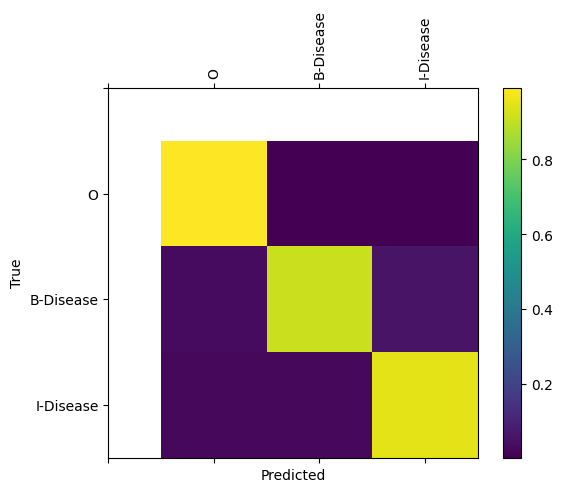

In [17]:
ner_model.half().evaluate_from_file(  # 使用 evaluate_from_file 方法评估模型性能，并使用 half() 将模型转换为半精度
    text_file=os.path.join(NER_DATA_DIR, 'sample_text_dev.txt'),  # 指定评估使用的文本文件路径
    labels_file=os.path.join(NER_DATA_DIR, 'sample_labels_dev.txt'),  # 指定评估使用的标签文件路径
    output_dir=WORK_DIR,  # 指定评估结果保存的目录
    add_confusion_matrix=True,  # 指定是否计算混淆矩阵
    normalize_confusion_matrix=True,  # 指定是否对混淆矩阵进行归一化处理
    batch_size=1  # 指定评估使用的批次大小
)


点击 ... 以显示解决方案。

In [ ]:
# 重启内核
import IPython  # 导入 IPython 库

app = IPython.Application.instance()  # 获取 IPython 应用实例
app.kernel.do_shutdown(True)  # 使用 do_shutdown 方法关闭当前内核，并将参数设置为 True 以强制关闭内核


**干得好！** 

<center><a href="https://5loi.com/about_loi"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>